# PREDICTING USED CAR PRICES IN THE UK

To predict used car prices in the UK, I decided to test out several different regression models and see which one worked best. I used an 80/20 train-test split for all my models, training on 80% of the data and testing on the remaining 20% to get a better sense of how each model would perform on new, unseen data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading the cleaned dataset
df = pd.read_csv('/content/cleaned_dataset.csv')

In [ ]:
df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox
0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual
1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual
2,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual
3,Hyundai Coupe,800,124196,2007,3.0,Petrol,Coupe,2.0L,Manual
4,Peugeot 207,1299,87000,2008,5.0,Diesel,Hatchback,1.6L,Manual


In [ ]:
#Preparing the data

# Define features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model

As a baseline model, I simply predicted the mean price from the training data for all test examples. This provides a basic benchmark to compare the performance of more complex models against a simple average-based prediction.

In [ ]:
# Predict the mean price for all test samples
mean_price = y_train.mean()
baseline_preds = np.full(shape=len(y_test), fill_value=mean_price)

# Evaluate the baseline
baseline_mse = mean_squared_error(y_test, baseline_preds)
baseline_mse

23290338.306960512

# Multiple Regression Model

In [ ]:
# Define categorical and numerical columns
categorical_cols = ['Fuel type', 'Body type', 'Engine', 'Gearbox', 'title']
numerical_cols = ['Mileage(miles)', 'Registration_Year', 'Previous Owners']

In [ ]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

In [ ]:
# Create pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# Fit the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Fuel type', 'Body type',
                                                   'Engine', 'Gearbox',
                                                   'title']),
                                                 ('num', 'passthrough',
                                                  ['Mileage(miles)',
                                                   'Registration_Year',
                                                   'Previous Owners'])])),
                ('regressor', LinearRegression())])

In [ ]:
# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate MSE
multiple_regression_mse = mean_squared_error(y_test, y_pred)
multiple_regression_mse

5994152.976468068

In [ ]:
#determine feature importance
r = permutation_importance(model_pipeline, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
title,0.014858
Mileage(miles),0.093328
Registration_Year,0.777637
Previous Owners,0.017943
Fuel type,0.013444
Body type,0.040094
Engine,0.037060
Gearbox,0.099983


In [ ]:
# Finding the Coefficients of the numerical features
numerical_coeffs = model_pipeline.named_steps['regressor'].coef_[-len(numerical_cols):]

# Create a DataFrame
import pandas as pd
coefficients_table = pd.DataFrame({
    'Feature': numerical_cols,
    'Coefficient': numerical_coeffs
})

# Display the coefficients
print(coefficients_table)

             Feature  Coefficient
0     Mileage(miles)    -0.022666
1  Registration_Year   590.984533
2    Previous Owners  -329.062629


In [ ]:
# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.7426


In [ ]:
# Check for overfitting
# Predict on the training and test set
train_preds_lr = model_pipeline.predict(X_train) # Predict on training data
test_preds_lr = model_pipeline.predict(X_test)   # Predict on test data


# Calculate MSE for training and test sets
train_mse_lr = mean_squared_error(y_train, train_preds_lr)
test_mse_lr = mean_squared_error(y_test, test_preds_lr)

# Print results
print(f"Multiple Regression Training MSE: {train_mse_lr:.2f}")
print(f"Multiple Regression Testing MSE: {test_mse_lr:.2f}")

Multiple Regression Training MSE: 5646675.90
Multiple Regression Testing MSE: 5994152.98


# K-Nearest Neighbours (KNN) Regressor


In [ ]:
# Rebuild Preprocessor (now scaling numericals too)
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

In [ ]:
# Build pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('regressor', KNeighborsRegressor())
])

In [ ]:
# Set up GridSearchCV
param_grid = {
    'regressor__n_neighbors': list(range(1, 21))  # Try k = 1 to 20
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Train the model with GridSearch
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Fuel '
                                                                          'type',
                                                                          'Body '
                                                                          'type',
                                                                          'Engine',
                                                                          'Gearbox',
                                                                          'title']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Mileage(miles)',
                                                                          'Registration_Year',
                                                                          'Previous '
                                                                          'Owners'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
# Predict and evaluate
knn_best_model = grid_search.best_estimator_
knn_preds = knn_best_model.predict(X_test)

knn_mse = mean_squared_error(y_test, knn_preds)

print(f"Best k (number of neighbors): {grid_search.best_params_}")
print(f"KNN Regressor MSE: {knn_mse}")

Best k (number of neighbors): {'regressor__n_neighbors': 9}
KNN Regressor MSE: 3136259.38967749


In [ ]:
# Calculate R²
knn_r2 = r2_score(y_test, knn_preds)
print(f"KNN Regressor R² Score: {knn_r2:.4f}")

KNN Regressor R² Score: 0.8653


In [ ]:
# Compare Training vs Test MSE as sometimes, KNN overfits when k is small (like 4).
train_preds = knn_best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)

print(f"KNN Training MSE: {train_mse:.2f}")
print(f"KNN Test MSE: {knn_mse:.2f}")

KNN Training MSE: 2881639.07
KNN Test MSE: 3136259.39


In [ ]:
#determine feature importance
r = permutation_importance(knn_best_model, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())

,0
title,0.012839
Mileage(miles),0.119506
Registration_Year,0.588022
Previous Owners,0.077953
Fuel type,-0.001765
Body type,0.018575
Engine,0.022671
Gearbox,0.027699


# Decision Tree Regression Model

In [ ]:
# Preprocessor
preprocessor_dt = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

In [ ]:
# Build pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_dt),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [ ]:
# Set up GridSearchCV
param_grid = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

grid_search_dt = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Train the model with GridSearch
grid_search_dt.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Fuel '
                                                                          'type',
                                                                          'Body '
                                                                          'type',
                                                                          'Engine',
                                                                          'Gearbox',
                                                                          'title']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['Mileage(miles)',
                                                                          'Registration_Year',
                                                                          'Previous '
                                                                          'Owners'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 5, 10, 20],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
# Predict and evaluate
dt_best_model = grid_search_dt.best_estimator_
dt_preds = dt_best_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_preds)

print(f"Best Parameters: {grid_search_dt.best_params_}")
print(f"Decision Tree Regressor MSE: {dt_mse:.2f}")

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 10}
Decision Tree Regressor MSE: 3082803.76


In [ ]:
# Calculate R²
dt_r2 = r2_score(y_test, dt_preds)
print(f"Decision Tree R² Score: {dt_r2:.4f}")

Decision Tree R² Score: 0.8676


In [ ]:
# Checking for overfitting
train_preds_dt = dt_best_model.predict(X_train)
train_mse_dt = mean_squared_error(y_train, train_preds_dt)

print(f"Decision Tree Training MSE: {train_mse_dt:.2f}")
print(f"Decision Tree Test MSE: {dt_mse:.2f}")

Decision Tree Training MSE: 1006177.38
Decision Tree Test MSE: 3082803.76


In [ ]:
# Get feature names after OneHotEncoding
feature_names_dt = dt_best_model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances
importances_dt = dt_best_model.named_steps['regressor'].feature_importances_

# Create a table
import pandas as pd

feature_importances_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Importance': importances_dt
}).sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importances_dt.head(10))


                                     Feature  Importance
383                   num__Registration_Year    0.775530
41                       cat__Gearbox_Manual    0.058504
382                      num__Mileage(miles)    0.053776
23                          cat__Engine_2.0L    0.029464
6                   cat__Body type_Hatchback    0.013839
194  cat__title_Land Rover Range Rover Sport    0.005391
232       cat__title_Mercedes-Benz GLE Class    0.005218
31                          cat__Engine_3.0L    0.003914
18                          cat__Engine_1.5L    0.003864
384                     num__Previous Owners    0.003467


# Random Forrest Regressor

In [ ]:
# Preprocessor
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

In [ ]:
# Build pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [ ]:
# Set up GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Train the model with GridSearch
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Fuel '
                                                                          'type',
                                                                          'Body '
                                                                          'type',
                                                                          'Engine',
                                                                          'Gearbox',
                                                                          'title']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['Mileage(miles)',
                                                                          'Registration_Year',
                                                                          'Previous '
                                                                          'Owners'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [ ]:
# Predict and evaluate
rf_best_model = grid_search_rf.best_estimator_
rf_preds = rf_best_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_preds)

print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Random Forest Regressor MSE: {rf_mse:.2f}")

Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 300}
Random Forest Regressor MSE: 2203038.90


In [ ]:
# Calculate R²
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest Regressor R² Score: {rf_r2:.4f}")

Random Forest Regressor R² Score: 0.9054


In [ ]:
# Check for overfitting
train_preds_rf = rf_best_model.predict(X_train)
train_mse_rf = mean_squared_error(y_train, train_preds_rf)

print(f"Random Forest Training MSE: {train_mse_rf:.2f}")
print(f"Random Forest Test MSE: {rf_mse:.2f}")

Random Forest Training MSE: 360016.03
Random Forest Test MSE: 2203038.90


In [ ]:
# Get feature names after encoding
feature_names_rf = rf_best_model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances
importances_rf = rf_best_model.named_steps['regressor'].feature_importances_

# Create a DataFrame
import pandas as pd

feature_importances_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(feature_importances_rf.head(10))

                                     Feature  Importance
383                   num__Registration_Year    0.734958
41                       cat__Gearbox_Manual    0.064074
382                      num__Mileage(miles)    0.061289
23                          cat__Engine_2.0L    0.016308
6                   cat__Body type_Hatchback    0.015202
384                     num__Previous Owners    0.008333
10                        cat__Body type_SUV    0.006562
232       cat__title_Mercedes-Benz GLE Class    0.004162
194  cat__title_Land Rover Range Rover Sport    0.003802
11                     cat__Body type_Saloon    0.003663


# Neural Network (MLP Regressor)

In [ ]:
# Preprocessor
preprocessor_mlp = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

In [ ]:
# Build pipeline
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_mlp),
    ('regressor', MLPRegressor(max_iter=1000, random_state=42))
])

In [ ]:
# Set up GridSearchCV
param_grid = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'regressor__activation': ['relu', 'tanh']
}

grid_search_mlp = GridSearchCV(mlp_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Train the model with GridSearch
grid_search_mlp.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Fuel '
                                                                          'type',
                                                                          'Body '
                                                                          'type',
                                                                          'Engine',
                                                                          'Gearbox',
                                                                          'title']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Mileage(miles)',
                                                                          'Registration_Year',
                                                                          'Previous '
                                                                          'Owners'])])),
                                       ('regressor',
                                        MLPRegressor(max_iter=1000,
                                                     random_state=42))]),
             param_grid={'regressor__activation': ['relu', 'tanh'],
                         'regressor__hidden_layer_sizes': [(50,), (100,),
                                                           (50, 50)]},
             scoring='neg_mean_squared_error')

In [ ]:
# Predict and evaluate
mlp_best_model = grid_search_mlp.best_estimator_
mlp_preds = mlp_best_model.predict(X_test)

mlp_mse = mean_squared_error(y_test, mlp_preds)

print(f"Best Parameters: {grid_search_mlp.best_params_}")
print(f"Neural Network Regressor (MLP) MSE: {mlp_mse:.2f}")

Best Parameters: {'regressor__activation': 'relu', 'regressor__hidden_layer_sizes': (50, 50)}
Neural Network Regressor (MLP) MSE: 1898002.17


In [ ]:
# Calculate R²
mlp_r2 = r2_score(y_test, mlp_preds)
print(f"Neural Network Regressor (MLP) R² Score: {mlp_r2:.4f}")

Neural Network Regressor (MLP) R² Score: 0.9185


In [ ]:
# Check for overfitting
train_preds_mlp = mlp_best_model.predict(X_train)
train_mse_mlp = mean_squared_error(y_train, train_preds_mlp)

print(f"Neural Network Training MSE: {train_mse_mlp:.2f}")
print(f"Neural Network Test MSE: {mlp_mse:.2f}")

Neural Network Training MSE: 641915.77
Neural Network Test MSE: 1898002.17


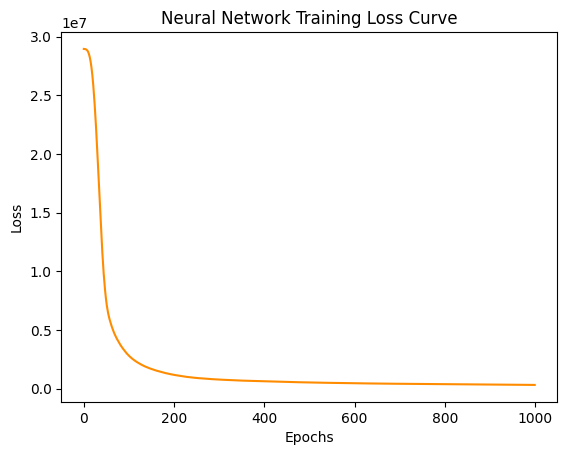

In [ ]:
#Training loss curve
plt.plot(mlp_best_model.named_steps['regressor'].loss_curve_, color = 'darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Neural Network Training Loss Curve')
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Assuming your trained model is called `mlp_model`
# and your test features and labels are `X_test` and `y_test`

# Calculate permutation importance
nn_importance = permutation_importance(
    mlp_best_model, X_test, y_test, n_repeats=10, random_state=42
)

# Organize into a nice pandas Series
nn_feature_importance = pd.Series(
    nn_importance.importances_mean,
    index=X_test.columns
)

# Sort features by importance
nn_feature_importance = nn_feature_importance.sort_values(ascending=False)

# Display
print(nn_feature_importance)

Registration_Year    1.071696
Mileage(miles)       0.173467
title                0.120873
Body type            0.038384
Gearbox              0.034591
Engine               0.029166
Fuel type            0.003325
Previous Owners      0.001013
dtype: float64


# Model Comparison

In [ ]:
# Store all MSEs
model_mse_scores = {
    'Baseline (Mean Prediction)': baseline_mse,           # your baseline MSE
    'Multiple Regression': multiple_regression_mse,
    'KNN Regressor': knn_mse,
    'Decision Tree Regressor': dt_mse,
    'Random Forest Regressor': rf_mse,
    'Neural Network (MLP)': mlp_mse
}

# Convert to DataFrame for easier plotting
import pandas as pd

model_mse_df = pd.DataFrame.from_dict(model_mse_scores, orient='index', columns=['MSE'])
model_mse_df = model_mse_df.sort_values(by='MSE', ascending=True)

# Display the table
print(model_mse_df)

                                     MSE
Neural Network (MLP)        1.898002e+06
Random Forest Regressor     2.203039e+06
Decision Tree Regressor     3.082804e+06
KNN Regressor               3.136259e+06
Multiple Regression         5.994153e+06
Baseline (Mean Prediction)  2.329034e+07


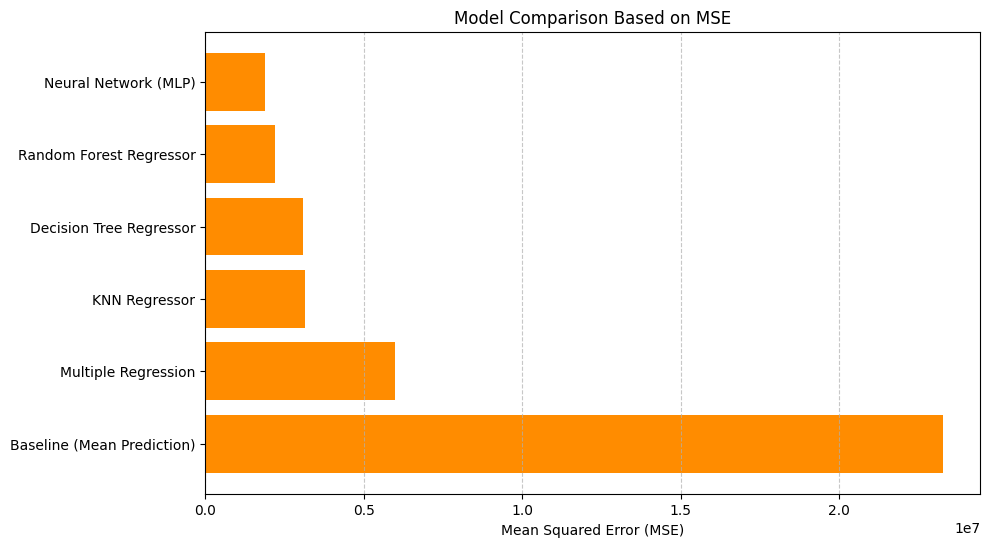

In [ ]:
# Plot
plt.figure(figsize=(10,6))
plt.barh(model_mse_df.index, model_mse_df['MSE'], color='darkorange')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('Model Comparison Based on MSE')
plt.gca().invert_yaxis()  # best model on top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()